Quora Questions Pairs classification based on Gensim Word2Vec embeddings (Google News corpus) weighted by TFIDF's IDF of each Word in Questions

In [2]:
import gensim
import numpy as np
import pandas as pd
import re
import csv
import os
import nltk
import warnings
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Model, Sequential
from tensorflow.keras import Input
from keras.layers import LSTM, Dense, Embedding, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [3]:
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading Word2Vec keyed vectors from Google News corpus

In [5]:
EMBEDDING_FILE = '/content/drive/MyDrive/Copy-CDS-B3/Capstone/NN/GoogleNews-vectors-negative300.bin.gz'
w2v_model = KeyedVectors.load_word2vec_format(EMBEDDING_FILE,binary=True)

Reading cleaned Quora Questions Pairs Training Data

In [6]:
trainpath = '/content/drive/MyDrive/Copy-CDS-B3/Capstone/NN/cleaned_train_data.csv'
train_data = pd.read_csv(trainpath, delimiter=",", encoding='utf-8')
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,queslem1,queslem2
0,352313,690128,623007,how do i unlock icloud activation lock in ios 9,how do i unlock icloud activation lock in ios 7,0,how do i unlock icloud activation lock in io 9,how do i unlock icloud activation lock in io 7
1,168021,332061,332062,how do you hang a canvas painting,how do you hang fine art i have a painting on...,0,how do you hang a canvas painting,how do you hang fine art i have a painting on ...
2,145770,288446,288447,i have never gone to a bank how do i put mone...,i have never gone to a bank how do i put mone...,1,i have never gone to a bank how do i put money...,i have never gone to a bank how do i put money...
3,302553,594155,594156,can i own my own private jet in singapore,if you own a private jet how do you go about ...,0,can i own my own private jet in singapore,if you own a private jet how do you go about b...
4,317214,622459,622460,what are some common hawaiian last names,what are some common hawaiian surnames what a...,0,what are some common hawaiian last name,what are some common hawaiian surname what are...


Shuffling train data as the qid increases - duplicates go down, so shuffling data

In [8]:
train_data = train_data.iloc.sample(frac=1)
print(train_data.shape)
train_data.head()

(10000, 6)


,id,qid1,qid2,question1,question2,is_duplicate
8817,189285,373719,373720,what precautions should i take before marriage,what precautions should take in flu,0
9511,225680,444791,444792,what is it like flying non stop from san franc...,what is it like moving from san francisco to o...,0
4364,259395,510502,510503,why does not an airplane traveling in the oppo...,would the earth start spinning faster if every...,0
8563,228746,450782,450783,what is the male equivalent of mistress,what is the male version of a mistress,1
3122,389519,761434,761435,how does garlic help you lose weight,how can the garlic diet help you lose weight,1


Test for similar words related to car using w2v model

In [ ]:
w2v_model.wv.most_similar(positive=["car"])

In [ ]:
# merge texts
questions = list(train_data['question1'].astype('str')) + list(train_data['question2'].astype('str'))

Build a dcitionary of TFIDF Inverse Document Frequency of each word in Questions

In [ ]:
tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value: idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [ ]:
wrdsplitqs = []
for row in questions: 
    wrdsplitqs.append([word for word in row.split()]) 

In [ ]:
vec_data = []
for row in tqdm(wrdsplitqs):
    vec = np.zeros(300)
    count = 0
    for word in row:
        try:
            if word in w2v_model.vocab and word in word2tfidf.keys():
                vec = vec + w2v_model.wv[word] * word2tfidf[str(word)] 
            elif word in w2v_model.vocab:
                vec = vec + w2v_model.wv[word]   
        except:
            pass
    vec_data.append(vec)

100%|██████████| 808574/808574 [01:19<00:00, 10216.50it/s]


In [ ]:
vec_data[0]

array([-2.64756166e+00,  2.98120700e-01,  1.63515972e+00,  7.40797210e-01,
       -3.70741445e+00, -2.81723122e-01,  8.46178919e-01,  7.45186806e-01,
        5.32213658e-01,  1.41615291e+00,  2.67585093e+00, -1.91063248e+00,
       -1.30778195e+00,  1.23978875e+00,  1.60769388e+00,  2.13650393e+00,
        4.91902448e+00,  1.90165055e+00,  1.09997220e+00, -2.98896279e+00,
       -7.11376011e-01,  7.74468658e-01,  7.30547383e-02, -2.44776157e+00,
       -2.52327181e+00,  9.12874848e-01, -1.40157612e+00,  2.33302224e+00,
        1.61958383e+00,  6.66095823e-01,  3.51431381e-01,  1.47423541e+00,
       -1.14273489e-01, -2.03783244e+00, -1.17895104e+00, -9.58985388e-01,
       -1.76264587e+00,  1.34812831e+00, -4.79343832e-01, -1.66913867e-01,
       -1.53716091e-01,  6.10852614e-02,  1.93080746e-01,  8.32343102e-01,
       -1.84813865e+00, -3.66646503e+00,  1.16190536e+00, -6.90199482e-01,
        1.33499914e+00,  2.55793700e+00,  2.62729591e+00,  2.46838731e+00,
       -2.11451723e+00,  

In [ ]:
length = len(vec_data)
half = int(length/2)
first_half = vec_data[:half]
second_half = vec_data[length-half:]

In [ ]:
q1_arry = np.array(first_half)
q2_arry = np.array(second_half)

In [ ]:
q1_arry.shape, q2_arry.shape

((404287, 300), (404287, 300))

In [ ]:
tem_df1 = pd.DataFrame(q1_arry, index= train_data.index)
tem_df2 = pd.DataFrame(q2_arry, index= train_data.index)
tem_df = pd.concat([tem_df1, tem_df2], axis=1)

In [ ]:
final_df = pd.concat([tem_df, train_data['is_duplicate']], axis=1)
final_df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,is_duplicate
102699,-2.647562,0.298121,1.635160,0.740797,-3.707414,-0.281723,0.846179,0.745187,0.532214,1.416153,...,-1.142046,-4.453843,-1.108866,-0.189206,0.965213,4.447909,4.623130,2.336949,0.582702,1
386983,-0.633444,-1.609805,-0.404038,11.448592,0.920526,-0.284155,0.793558,3.088445,2.404882,2.251312,...,5.025103,-10.137586,-4.286212,-0.670638,1.397818,3.458420,-2.370034,2.054059,4.330425,1
1885,2.376750,1.770790,5.878913,2.620081,-9.103543,-3.841476,3.437771,-3.945854,4.333862,2.568056,...,2.057739,-4.869936,9.625833,-6.007779,-0.745526,-5.478261,0.831022,3.010750,0.745225,0
180528,1.722917,3.225685,1.782853,7.503135,-8.700540,4.773866,1.736932,-2.621658,5.459938,4.399462,...,13.649240,5.970926,4.135979,-1.966009,10.948300,-2.331280,1.320212,16.936270,-3.200964,0
281521,-0.270409,5.183115,2.726862,12.957077,-10.552280,4.146319,-0.189036,-5.905433,1.736106,4.915067,...,1.619101,-2.918767,0.746544,0.950727,-0.288510,-2.543471,-7.734882,3.445876,1.697702,1


In [ ]:
import gc
del(w2v_model)
del(train_data_tmp)
del(wrdsplitqs)
del(word2tfidf)
del(tfidf)
del(vec_data)
del(q1_arry)
del(q2_arry)
del(tem_df)
del(tem_df1)
del(tem_df2)
gc.collect()

80

In [ ]:
sentences = final_df.iloc[:,:-1].values
#y = final_df['is_duplicate'].values
y = pd.DataFrame(data=final_df.is_duplicate)

In [ ]:
questions_train, questions_test, y_train, y_test = train_test_split(sentences, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = metrics.confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divide each element of the confusion matrix with the sum of elements in that column
    
    B =(C/C.sum(axis=0))
    #divide each element of the confusion matrix with the sum of elements in that row
    
    plt.figure(figsize=(20,4))
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

def print_modelpred_metrics(y_test,y_pred):
    prediction = np.round(abs(y_pred))
    print ('Accuracy:  ', accuracy_score(y_test, prediction))
    print ('F1 score:  ', f1_score(y_test, prediction))
    print ('Recall:    ', recall_score(y_test, prediction))
    print ('Precision: ', precision_score(y_test, prediction))
    print ('\nclasification report:\n\n', classification_report(y_test,prediction))
    print ('\n confusion matrix:\n\n',confusion_matrix(y_test, prediction))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
questions_train = scaler.fit_transform(questions_train)

In [ ]:
X_1_train, X_2_train = questions_train[:,:300],questions_train[:,300:]
X_1_train.shape,X_2_train.shape

((323429, 300), (323429, 300))

In [ ]:
del(final_df)
del(questions_train)
del(sentences)
gc.collect()

241

In [ ]:
from keras import layers
from keras.models import Input, Model, Sequential
from keras.layers import Concatenate, Dense, Activation, Dropout
from keras.callbacks import EarlyStopping

ishape = X_1_train.shape[1]
inputs1 = Input(shape=ishape)
inputs2 = Input(shape=ishape)

sharedBranch = layers.Dense(300, activation="tanh")

branch1 = sharedBranch(inputs1)
branch2 = sharedBranch(inputs2)

concatenated1 = Concatenate( name='Concatenate_1')([branch1,branch2])

final_model = layers.Dense(128, activation="relu")(concatenated1)
final_model = layers.Dropout(0.2)(final_model)
final_model = layers.Dense(64, activation="relu")(final_model)
final_model = layers.Dropout(0.2)(final_model)
output = layers.Dense(1, activation="sigmoid")(final_model)

mainmodel = Model(inputs=[inputs1,inputs2], outputs=output)

In [ ]:
mainmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='auto')
history = mainmodel.fit([X_1_train, X_2_train], y_train, batch_size=100, epochs=20, verbose=1,callbacks=[early], validation_split=0.1)

Epoch 1/20
2911/2911 [==============================] - 12s 3ms/step - loss: 0.5095 - accuracy: 0.7376 - val_loss: 0.4608 - val_accuracy: 0.7696
Epoch 2/20
2911/2911 [==============================] - 10s 3ms/step - loss: 0.4520 - accuracy: 0.7744 - val_loss: 0.4386 - val_accuracy: 0.7864
Epoch 3/20
2911/2911 [==============================] - 10s 3ms/step - loss: 0.4202 - accuracy: 0.7947 - val_loss: 0.4291 - val_accuracy: 0.7865
Epoch 4/20
2911/2911 [==============================] - 10s 3ms/step - loss: 0.3942 - accuracy: 0.8106 - val_loss: 0.4199 - val_accuracy: 0.7959
Epoch 5/20
2911/2911 [==============================] - 10s 3ms/step - loss: 0.3713 - accuracy: 0.8247 - val_loss: 0.4111 - val_accuracy: 0.7999
Epoch 6/20
2911/2911 [==============================] - 10s 3ms/step - loss: 0.3497 - accuracy: 0.8352 - val_loss: 0.4165 - val_accuracy: 0.8019
Epoch 7/20
2911/2911 [==============================] - 10s 3ms/step - loss: 0.3312 - accuracy: 0.8459 - val_loss: 0.4169 - val_ac

In [ ]:
questions_test = scaler.transform(questions_test)

In [ ]:
X_1_test, X_2_test = questions_test[:,:300],questions_test[:,300:]
X_1_test.shape,X_2_test.shape

((80858, 300), (80858, 300))

In [ ]:
y_pred = mainmodel.predict([X_1_test, X_2_test])

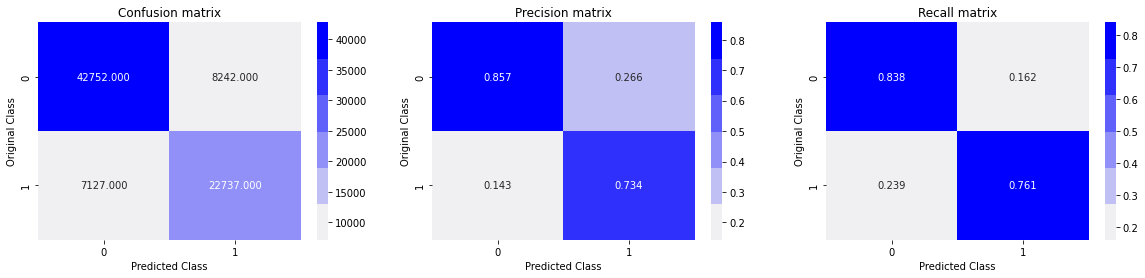

In [ ]:
plot_confusion_matrix(y_test, np.round(abs(y_pred)))

In [ ]:
print_modelpred_metrics(y_test,y_pred)

Accuracy:   0.8099260431868214
F1 score:   0.7473990434396726
Recall:     0.7613514599517814
Precision:  0.7339488040285355

clasification report:

               precision    recall  f1-score   support

           0       0.86      0.84      0.85     50994
           1       0.73      0.76      0.75     29864

    accuracy                           0.81     80858
   macro avg       0.80      0.80      0.80     80858
weighted avg       0.81      0.81      0.81     80858


 confusion matrix:

 [[42752  8242]
 [ 7127 22737]]


In [ ]:
y_test1 = y_test.copy()
y_test1['pred_prob'] = y_pred
y_test1['rounded_pred'] = np.round(abs(y_pred))
mergedf = pd.merge(train_data[['question1','question2']], y_test1, left_index = True, right_index = True)
mergedf.to_csv('qqp_tfidf_word2vec_predicted_output.csv')